# Cifar10

In this exercise we will try to create a CNN that will classify not 2 but 10 different image labels. We get the images from the dataset named [Cifar10](http://www.cs.utoronto.ca/~kriz/cifar.html)

* Import :
  * Tensorflow
  * Numpy
  * Matplotlib.pyplot

In [1]:
import json
import math
from plotly import graph_objects as go
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy


import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
print(tf.__version__)

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print (f"In Colab : {IN_COLAB}")

from pathlib import Path
if not IN_COLAB:
    k_Content_dir = Path.cwd()/"content"
else:
    k_Content_dir = Path("/content")
print(k_Content_dir)

color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

k_epochs = 3

2.10.0
In Colab : False
c:\Users\phili\OneDrive\Documents\Programmation\Formations_JEDHA\02_Data_Science_Fullstack_march_2024\07_deep_learning\05_CNN_Convolutional\content


* Using `tf.keras.utils.get_file` load the image files into your storage with this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip`

In [2]:
#
# ! ATTENTION sur PC il a tendance à sauver dans C:/content/cifar10.zip
# Y a 50 000 fichiers

# Bien voir le extract=True qui fait qu'on se retrouve avec un répertoire /train
tf.keras.utils.get_file(
    k_Content_dir/"cifar10.zip",
    origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/train.zip",
    extract=True,
    cache_subdir=k_Content_dir
)

119728390/119728390 [==============================] - 3s 0us/step


'c:\\Users\\phili\\OneDrive\\Documents\\Programmation\\Formations_JEDHA\\02_Data_Science_Fullstack_march_2024\\07_deep_learning\\05_CNN_Convolutional\\content\\cifar10.zip'

* Import the dataframe containing the labels from this link `https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv`

In [3]:

data = pd.read_csv("https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/cifar-10/trainLabels.csv")
data.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


* Turn the `id` column into string type and add `.png` at the end of each string for the filenames to be complete

In [4]:
data["id"] = data["id"].astype("str") + ".png"
data.head()

,id,label
0,1.png,frog
1,2.png,truck
2,3.png,truck
3,4.png,deer
4,5.png,automobile


* Load and display an image of your dataset

In [5]:
# ATTENTION sur PC plt.imgshow part en vrille dans un environnement où y a TF
# Marche sur la machine de Raphael
# Dans un environnement "normal" bien sûr imshow affiche correctement
# Je ne sais pas vraiment ce que retourne .image.docode_png()

img = tf.io.read_file(str(k_Content_dir/"train/1.png"))  # on est obligé de convertir car tf.io.read_file comprend rien
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)

: 

* View a random image of each of your labels in your dataset * View a random image of each of your labels in your dataset

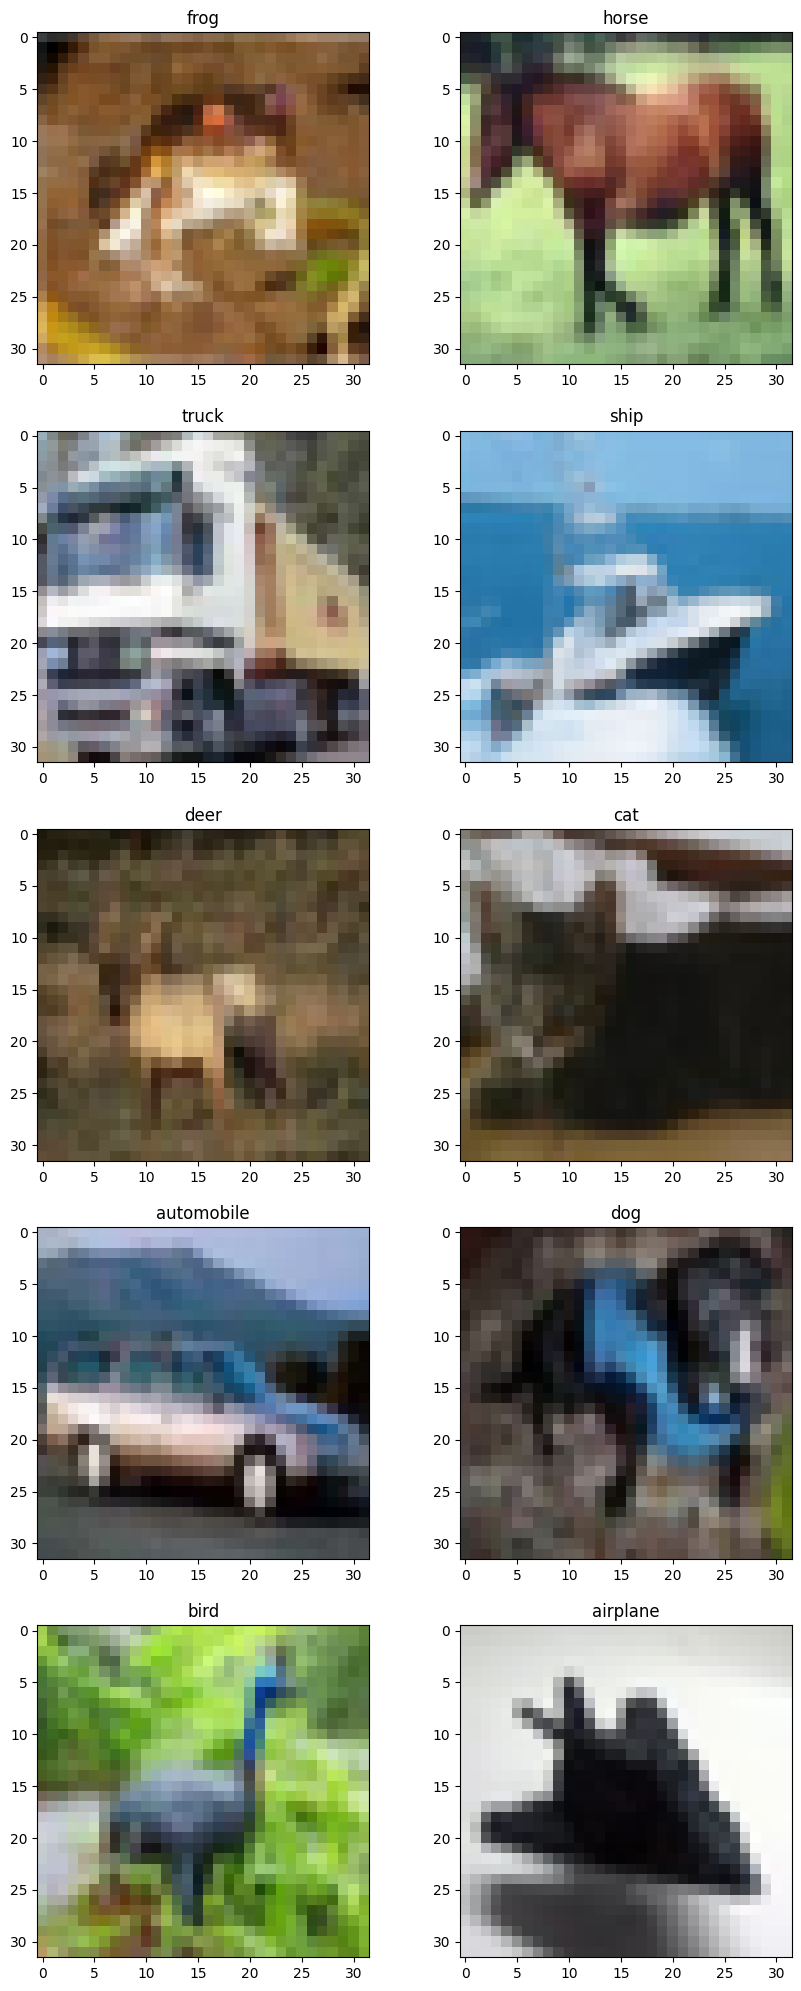

In [61]:
data_per_label = data.loc[data["label"].duplicated()==False]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,25))
for i in range(5):
  for j in range(2):
    filename = str(k_Content_dir) + "/train/" + data_per_label.iloc[i+j*5,0]
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels=3)
    axes[i,j].imshow(img)
    axes[i,j].title.set_text(data_per_label.iloc[i+j*5,1])

* Define an instance of an `ImageDataGenerator` Class with the data augmentation parameters of your choice, and `validation_split=0.3` (In the correction we will use data augmentation parameters that do not force us to fill empty pixels with new values)

In [62]:

img_generator = ImageDataGenerator(
    rotation_range=0,         # Angle range for random image rotation
    width_shift_range=0.0,    # Random shift of the image along width axis
    height_shift_range=0.0,   # Random shift of the image along height axis
    brightness_range=(0.5,1), # Random brightness modification
    shear_range=0.0,          # Random distortion of the image
    zoom_range=0.0,           # Random zoom on the image
    channel_shift_range=50.0, # Random hue modification
    horizontal_flip=True,     # Randomly flips image horizontally
    vertical_flip=True,       # Randomly flips image virtically
    rescale=1/255.,           # Rescaling values from [0,255]->[0,1]
    fill_mode='wrap',
    validation_split=0.3      # Portion of the data that can be saved for validation
)

* Set up one generator for the train data and one for the test data using the method that lets you generate data with a dataframe. Since we have many images in this dataset, we will create large batches of 64 images.
Use a target size of `(32,32)` and class_mode `"sparse"`

In [63]:
train_generator = img_generator.flow_from_dataframe(
    dataframe=data,                     # the dataframe containing the filename and label column
    directory=k_Content_dir/"train",    # the directory containing the image files
    x_col="id",                         # the name of the column with the filenames
    y_col="label",                      # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse",
    batch_size=64,
    shuffle = True,
    subset = "training"
)

val_generator = img_generator.flow_from_dataframe(
    dataframe=data,                     # the dataframe containing the filename and label column
    directory=k_Content_dir/"train",    # the directory containing the image files
    x_col="id",                         # the name of the column with the filenames
    y_col="label",                      # the name of the column with the labels
    target_size=(32,32),
    class_mode = "sparse",
    batch_size=64,
    shuffle = True,
    subset = "validation"
)

Found 35000 validated image filenames belonging to 10 classes.
Found 15000 validated image filenames belonging to 10 classes.


* Display a batch of data of train data

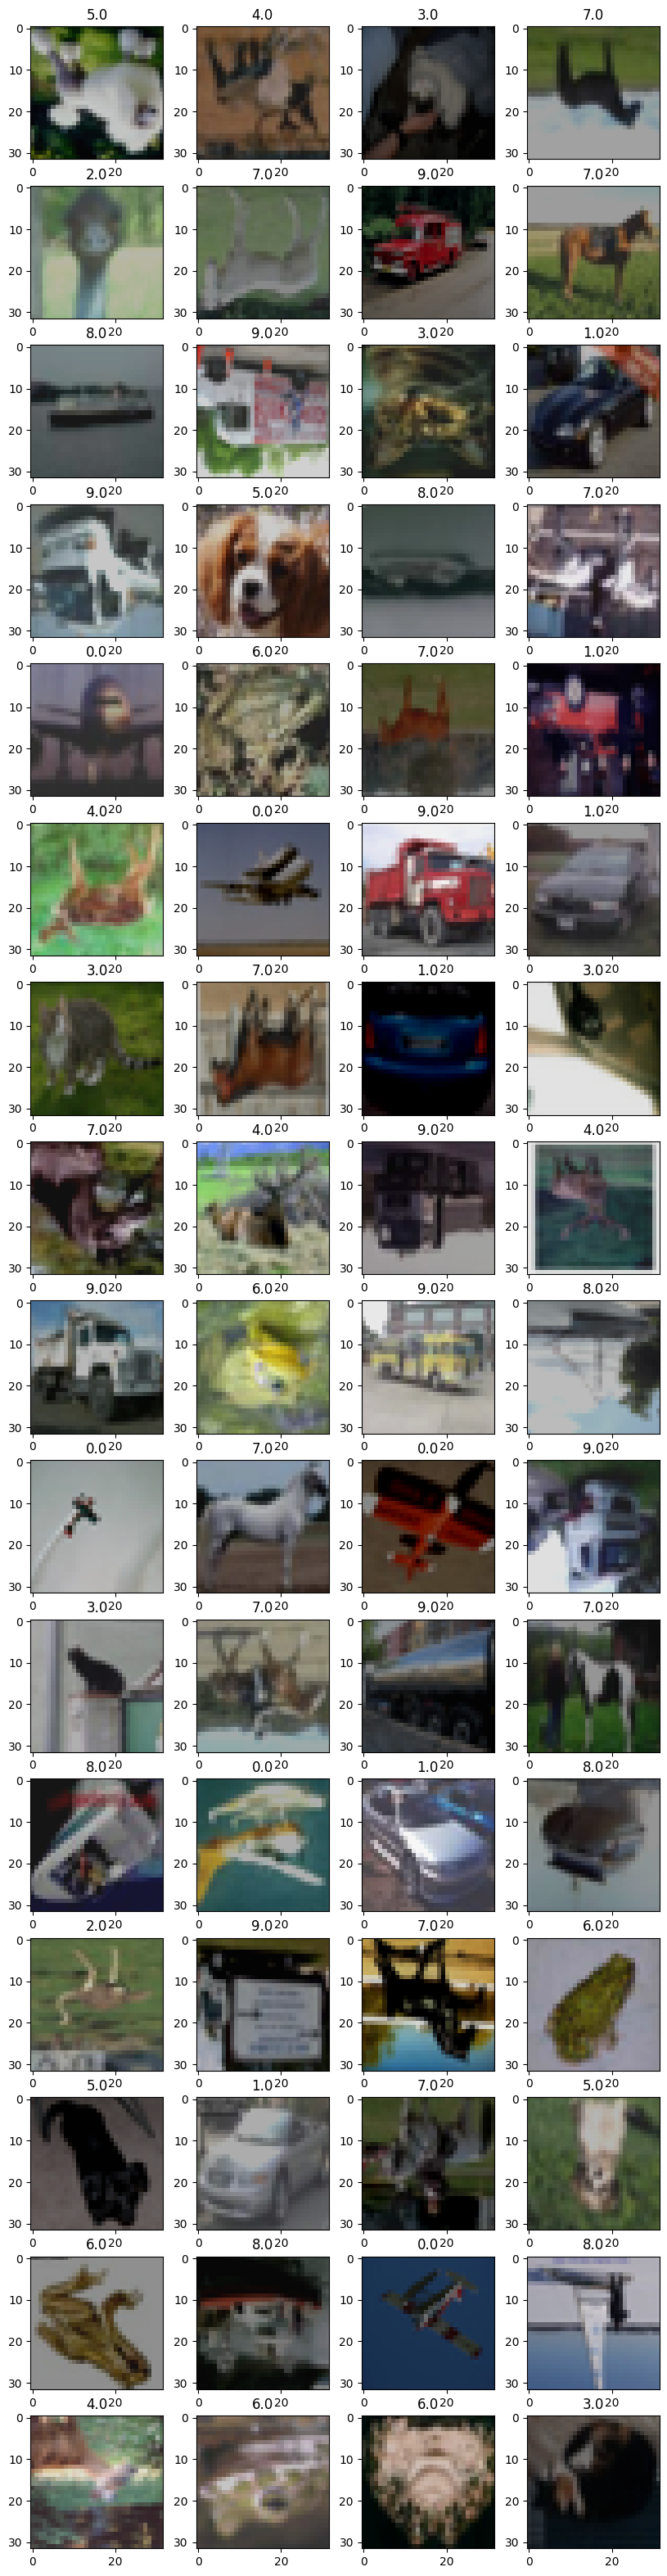

In [64]:
imgs, targets = next(iter(train_generator))
fig, ax = plt.subplots(16, 4, figsize=(10,40))
for i, (img, target) in enumerate(zip(imgs, targets)):
  ax[i-16*(i//16),i//16].imshow(img)
  ax[i-16*(i//16),i//16].title.set_text(str(target))
fig.show()

* How many times can you divide the images by two along each axis until you reduce the images to single pixel?

In [65]:
a=32
print(math.log2(a))


5.0


5 times!

* Build a neural network with a single convolution layer with 32 neurons, kernel size `(3,3)`, padding `"same"`, and activation `"relu"`, a max pooling layer, a flatten layer, then finish up the network with a dense layer that can predict the target variable.

In [66]:


# Dans l'ennoncé ils disent 32 neurons en fait c'est bien 32 filtres
# Y avait pas activation='relu'
model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Flatten(),                         # this layer turns multi-dimensional images into flat objects
     Dense(10, activation="softmax")    # 10 classes
    ]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          81,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 82,826 (323.54 KB)

 Trainable params: 82,826 (323.54 KB)

 Non-trainable params: 0 (0.00 B)

* Compile the model using the right loss function and metric(s) and the Adam optimizer with default learning rate

In [67]:

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

* Train the model over 50 epochs

In [68]:
model.fit(train_generator, epochs=k_epochs, validation_data=val_generator)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


547/547 ━━━━━━━━━━━━━━━━━━━━ 50s 88ms/step - loss: 1.9670 - sparse_categorical_accuracy: 0.2865 - val_loss: 1.6589 - val_sparse_categorical_accuracy: 0.4106
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 1.6339 - sparse_categorical_accuracy: 0.4250 - val_loss: 1.5415 - val_sparse_categorical_accuracy: 0.4538
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - loss: 1.5366 - sparse_categorical_accuracy: 0.4568 - val_loss: 1.5265 - val_sparse_categorical_accuracy: 0.4547


* Save the model under `cifar10model1conv.h5`

In [69]:
model.save(k_Content_dir/"cifar10model1conv.h5")

* Use the following code to save the model's history (it does not get saved with the model)

In [70]:

# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open(k_Content_dir/"cifar10model1convhistory.json", 'w'))

# ATTENTION : utiliser la cellule ci-dessous si on veut pas attendre 3H...
### Mais le format sur S3 est en Oct 2024 obsolete... Donc c'est mort

In [ ]:
# You may get the model's history with this code (for instructors not to have to train the whole model during the session)
# tf.keras.utils.get_file(k_Content_dir/"cifar10model1convhistory.json", origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1convhistory.json")

# Load the history .json file using the following command (for instructors)
# history_dict = json.load(open(k_Content_dir/"cifar10model1convhistory.json", 'r'))

# Load the previously saved model using the two following commands (for instructors)
# tf.keras.utils.get_file(k_Content_dir/"cifar10model1conv.h5", origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model1conv.h5")

# Define custom objects to handle the 'auto' reduction strategy
# custom_objects = {"SparseCategoricalCrossentropy": tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)} #SUM_OVER_BATCH_SIZE
# Replace 'SUM_OVER_BATCH_SIZE' with the appropriate reduction if known, or try other options like 'SUM' or 'NONE'.

# model = tf.keras.models.load_model(k_Content_dir/"cifar10model1conv.h5")
# Load the model with custom objects
# model = tf.keras.models.load_model(k_Content_dir/"cifar10model1conv.h5", custom_objects=custom_objects)




* Display the evolution of the loss and the validation loss using plotly

In [71]:


history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

The model looks it starts to overfit after 30 epochs and it trains smoothly on the training data.

* Build a new model and add a new convolution layer with double the number of neurons on it followed by a max pooling, and reproduce all the same steps as before.

In [72]:
# On avait
# Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
# MaxPool2D(),
# Flatten(),                                # this layer turns multi-dimensional images into flat objects
# Dense(10, activation="softmax")

# Y avait pas activation='relu'

model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,362 (235.79 KB)

 Trainable params: 60,362 (235.79 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [74]:
model.fit(train_generator, epochs=k_epochs, validation_data=val_generator)

Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - loss: 1.9647 - sparse_categorical_accuracy: 0.2792 - val_loss: 1.6103 - val_sparse_categorical_accuracy: 0.4287
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 73s 72ms/step - loss: 1.5281 - sparse_categorical_accuracy: 0.4560 - val_loss: 1.4050 - val_sparse_categorical_accuracy: 0.5019
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 45s 82ms/step - loss: 1.3748 - sparse_categorical_accuracy: 0.5130 - val_loss: 1.3135 - val_sparse_categorical_accuracy: 0.5355


In [75]:
model.save(k_Content_dir/"cifar10model2conv.h5")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open(k_Content_dir/"cifar10model2convhistory.json", 'w'))

# ATTENTION : utiliser la cellule ci-dessous si on veut pas attendre 3H...
### Mais le format sur S3 est en Oct 2024 obsolete... Donc c'est mort

In [ ]:
# tf.keras.utils.get_file(k_Content_dir/"cifar10model2convhistory.json",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2convhistory.json")
# tf.keras.utils.get_file(k_Content_dir/"cifar10model2conv.h5",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model2conv.h5")
# history_dict = json.load(open(k_Content_dir/"cifar10model2convhistory.json", 'r'))
# model = tf.keras.models.load_model(k_Content_dir/"cifar10model2conv.h5")

In [76]:


history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Here it seems pretty clear that just by adding a second convolutional layer in our network we are able to reach lower values of the loss function in fewer epochs, and despite the fact that our second model has much fewer parameters!

Repeat the same steps adding a third convolutional layer with `128` neurons on it, followed my a max pooling layer.

In [77]:
# On avait
#     Conv2D(32, (3,3), padding="same", input_shape=(imgs.shape[1:])),
#     MaxPool2D(),
#     Conv2D(64, (3,3), padding="same"),
#     MaxPool2D(),
#     Flatten(),
#     Dense(10, activation="softmax")

# Y avait pas activation='relu'

model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=k_epochs, validation_data=val_generator)

Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - loss: 1.9730 - sparse_categorical_accuracy: 0.2650 - val_loss: 1.5715 - val_sparse_categorical_accuracy: 0.4247
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step - loss: 1.4859 - sparse_categorical_accuracy: 0.4694 - val_loss: 1.3541 - val_sparse_categorical_accuracy: 0.5167
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 72s 74ms/step - loss: 1.3126 - sparse_categorical_accuracy: 0.5331 - val_loss: 1.2574 - val_sparse_categorical_accuracy: 0.5535


In [79]:
model.save(k_Content_dir/"cifar10model3conv.h5")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open(k_Content_dir/"cifar10model3convhistory.json", 'w'))

# ATTENTION : utiliser la cellule ci-dessous si on veut pas attendre 3H...
### Mais le format sur S3 est en Oct 2024 obsolete... Donc c'est mort

In [ ]:
# tf.keras.utils.get_file(k_Content_dir/"cifar10model3convhistory.json",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3convhistory.json")
# tf.keras.utils.get_file(k_Content_dir/"cifar10model3conv.h5",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model3conv.h5")
# history_dict = json.load(open(k_Content_dir/"cifar10model3convhistory.json", 'r'))
# model = tf.keras.models.load_model(k_Content_dir/"cifar10model3conv.h5")

In [80]:

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

* Let's build the same model and double the number of convolutional neurons on each layer.

In [81]:
# On avait
#      Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
#      MaxPool2D(),
#      Conv2D(64, (3,3), padding="same", activation='relu'),
#      MaxPool2D(),
#      Conv2D(128, (3,3), padding="same", activation='relu'),
#      MaxPool2D(),
#      Flatten(),
#      Dense(10, activation="softmax")

model = Sequential(
    [
     Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Conv2D(256, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          40,970 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 411,786 (1.57 MB)

 Trainable params: 411,786 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=k_epochs, validation_data=val_generator)

Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - loss: 1.9277 - sparse_categorical_accuracy: 0.2865 - val_loss: 1.5295 - val_sparse_categorical_accuracy: 0.4375
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 78s 74ms/step - loss: 1.4120 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.2847 - val_sparse_categorical_accuracy: 0.5425
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 42s 76ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.5678 - val_loss: 1.1361 - val_sparse_categorical_accuracy: 0.5983


In [83]:
model.save(k_Content_dir/"cifar10model4conv.h5")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open(k_Content_dir/"cifar10model4convhistory.json", 'w'))

# ATTENTION : utiliser la cellule ci-dessous si on veut pas attendre 3H...
### Mais le format sur S3 est en Oct 2024 obsolete... Donc c'est mort

In [84]:
# tf.keras.utils.get_file(k_Content_dir/"cifar10model4convhistory.json",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4convhistory.json")
# tf.keras.utils.get_file(k_Content_dir/"cifar10model4conv.h5",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model4conv.h5")
# history_dict = json.load(open(k_Content_dir/"cifar10model4convhistory.json", 'r'))
# model = tf.keras.models.load_model(k_Content_dir/"cifar10model4conv.h5")

In [85]:

history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Increasing the number of neurons on each layer is causing the model to quickly overfit! But it trains really on the training data.

* In the time remaining, build a model by duplicating the convolutional layers before every maxpooling adn go back to the original number of neurons. Look at the model summary for reference. This last model will have 6 different convolutional layers, let's see the effect of this on the predictions

In [87]:
# On avait

    #  Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
    #  MaxPool2D(),
    #  Conv2D(128, (3,3), padding="same", activation='relu'),
    #  MaxPool2D(),
    #  Conv2D(256, (3,3), padding="same", activation='relu'),
    #  MaxPool2D(),
    #  Flatten(),
    #  Dense(10, activation="softmax")


model = Sequential(
    [
     Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(imgs.shape[1:])),
     Conv2D(32, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Conv2D(64, (3,3), padding="same", activation='relu'),
     Conv2D(64, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Conv2D(128, (3,3), padding="same", activation='relu'),
     Conv2D(128, (3,3), padding="same", activation='relu'),
     MaxPool2D(),
     Flatten(),
     Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 307,498 (1.17 MB)

 Trainable params: 307,498 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])
model.fit(train_generator, epochs=k_epochs, validation_data=val_generator)

Epoch 1/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - loss: 2.0098 - sparse_categorical_accuracy: 0.2374 - val_loss: 1.5637 - val_sparse_categorical_accuracy: 0.4189
Epoch 2/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 75ms/step - loss: 1.4841 - sparse_categorical_accuracy: 0.4587 - val_loss: 1.3128 - val_sparse_categorical_accuracy: 0.5235
Epoch 3/3
547/547 ━━━━━━━━━━━━━━━━━━━━ 92s 93ms/step - loss: 1.2390 - sparse_categorical_accuracy: 0.5496 - val_loss: 1.1553 - val_sparse_categorical_accuracy: 0.5891


In [89]:
model.save(k_Content_dir/"cifar10model5conv.h5")

# Get the dictionary containing each metric and the loss for each epoch
history_dict = model.history.history
# Save it under the form of a json file
json.dump(history_dict, open(k_Content_dir/"cifar10model5convhistory.json", 'w'))

# ATTENTION : utiliser la cellule ci-dessous si on veut pas attendre 3H...
### Mais le format sur S3 est en Oct 2024 obsolete... Donc c'est mort

In [90]:
# tf.keras.utils.get_file(k_Content_dir/"cifar10model5convhistory.json",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5convhistory.json")
# tf.keras.utils.get_file(k_Content_dir/"cifar10model5conv.h5",
#                         origin="https://full-stack-assets.s3.eu-west-3.amazonaws.com/datasets/M08/CNN_models/cifar10model5conv.h5")
# history_dict = json.load(open(k_Content_dir/"cifar10model5convhistory.json", 'r'))
# model = tf.keras.models.load_model(k_Content_dir/"cifar10model5conv.h5")

In [91]:


history = history_dict
fig = go.Figure(data=[
                      go.Scatter(
                          y=history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'
)
fig.show()

Adding more convolutional layers helps a little but does not really improve the results for this dataset.